<a href="https://www.kaggle.com/code/liansnjambi/yolov5-real-time-number-plate-recognition?scriptVersionId=128173547" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/number-plate-detection/data.yaml
/kaggle/input/number-plate-detection/images/N148.xml
/kaggle/input/number-plate-detection/images/N177.xml
/kaggle/input/number-plate-detection/images/N40.jpeg
/kaggle/input/number-plate-detection/images/N176.jpeg
/kaggle/input/number-plate-detection/images/N173.xml
/kaggle/input/number-plate-detection/images/N129.jpeg
/kaggle/input/number-plate-detection/images/N114.jpeg
/kaggle/input/number-plate-detection/images/N231.jpeg
/kaggle/input/number-plate-detection/images/N69.jpeg
/kaggle/input/number-plate-detection/images/N213.xml
/kaggle/input/number-plate-detection/images/N119.xml
/kaggle/input/number-plate-detection/images/N212.jpeg
/kaggle/input/number-plate-detection/images/N52.jpeg
/kaggle/input/number-plate-detection/images/N103.xml
/kaggle/input/number-plate-detection/images/N154.jpeg
/kaggle/input/number-plate-detection/images/N166.xml
/kaggle/input/number-plate-detection/images/N127.xml
/kaggle/input/number-plate-detection/images/N1

## Importing the necessary Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob
from skimage import io
from shutil import copy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path = glob('../input/number-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [4]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/number-plate-detection/images/N148.xml,244,369,240,293
1,../input/number-plate-detection/images/N177.xml,331,538,263,317
2,../input/number-plate-detection/images/N173.xml,80,335,150,243
3,../input/number-plate-detection/images/N213.xml,131,209,129,153
4,../input/number-plate-detection/images/N119.xml,180,559,216,314


In [5]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../input/number-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'../input/number-plate-detection/images/N148.jpeg'

In [6]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['../input/number-plate-detection/images/N148.jpeg',
 '../input/number-plate-detection/images/N177.jpeg',
 '../input/number-plate-detection/images/N173.jpeg',
 '../input/number-plate-detection/images/N213.jpeg',
 '../input/number-plate-detection/images/N119.jpeg',
 '../input/number-plate-detection/images/N103.jpeg',
 '../input/number-plate-detection/images/N166.jpeg',
 '../input/number-plate-detection/images/N127.jpeg',
 '../input/number-plate-detection/images/N162.jpeg',
 '../input/number-plate-detection/images/N198.jpeg']

In [7]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'../input/number-plate-detection/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,../input/number-plate-detection/images/N148.xml,244,369,240,293,../input/number-plate-detection/images/N148.jpeg,600,430
1,../input/number-plate-detection/images/N177.xml,331,538,263,317,../input/number-plate-detection/images/N177.jpeg,850,681
2,../input/number-plate-detection/images/N173.xml,80,335,150,243,../input/number-plate-detection/images/N173.jpeg,445,349
3,../input/number-plate-detection/images/N213.xml,131,209,129,153,../input/number-plate-detection/images/N213.jpeg,350,196
4,../input/number-plate-detection/images/N119.xml,180,559,216,314,../input/number-plate-detection/images/N119.jpeg,678,475


In [8]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,../input/number-plate-detection/images/N148.xml,244,369,240,293,../input/number-plate-detection/images/N148.jpeg,600,430,0.510833,0.619767,0.208333,0.123256
1,../input/number-plate-detection/images/N177.xml,331,538,263,317,../input/number-plate-detection/images/N177.jpeg,850,681,0.511176,0.425844,0.243529,0.079295
2,../input/number-plate-detection/images/N173.xml,80,335,150,243,../input/number-plate-detection/images/N173.jpeg,445,349,0.466292,0.563037,0.573034,0.266476
3,../input/number-plate-detection/images/N213.xml,131,209,129,153,../input/number-plate-detection/images/N213.jpeg,350,196,0.485714,0.719388,0.222857,0.122449
4,../input/number-plate-detection/images/N119.xml,180,559,216,314,../input/number-plate-detection/images/N119.jpeg,678,475,0.544985,0.557895,0.558997,0.206316


In [9]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15637, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 15637 (delta 123), reused 167 (delta 97), pack-reused 15393
Receiving objects: 100% (15637/15637), 14.64 MiB | 26.40 MiB/s, done.
Resolving deltas: 100% (10651/10651), done.


In [10]:
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 whic

In [11]:
mkdir /kaggle/working/yolov5/data_images/

In [12]:
mkdir /kaggle/working/yolov5/data_images/test/

In [13]:
mkdir /kaggle/working/yolov5/data_images/train/

In [14]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [15]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In [16]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=3bf219fbd7e02d1f08ad04326c0d95adea38f243de3d241cbe6de3079c0c5bb5
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  6% |  1% |
|  1 |  0% |  0% |


In [17]:
!python ./yolov5/train.py --data ../input/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=../input/number-plate-detection/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval

In [18]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-162-gc3e4e94 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.0.0...
TorchScript: export success ✅ 2.4s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.13.1...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
=====================

In [19]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640


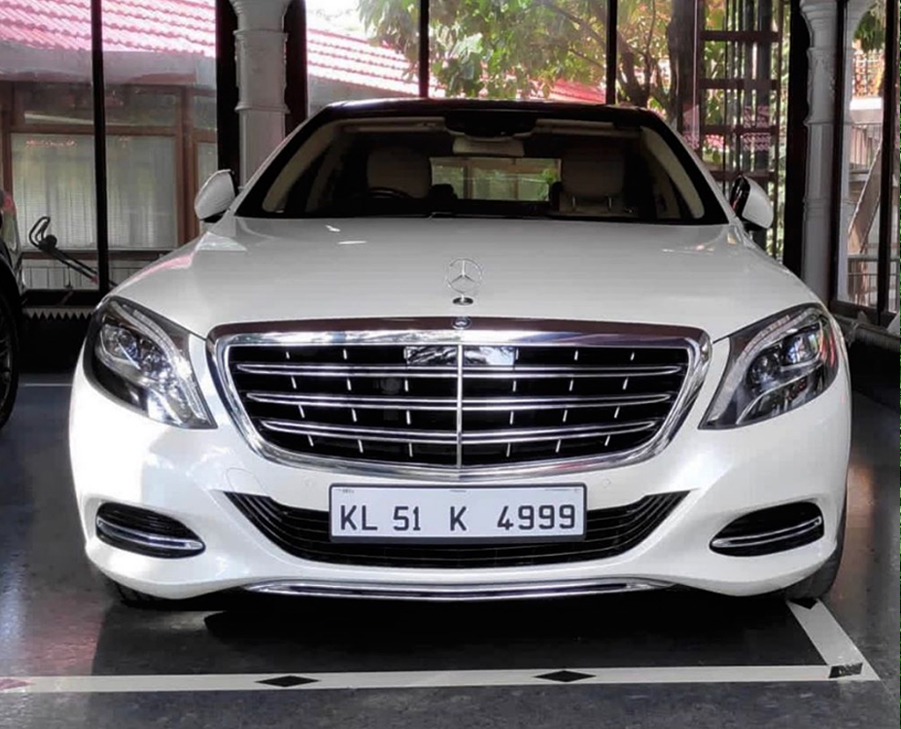

In [20]:
# LOAD THE IMAGE
img = io.imread('../input/number-plate-detection/TEST/TEST.jpeg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [21]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [22]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [23]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [24]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [25]:
# test
img = io.imread('../input/number-plate-detection/TEST/TEST.jpeg')
results = yolo_predictions(img,net)


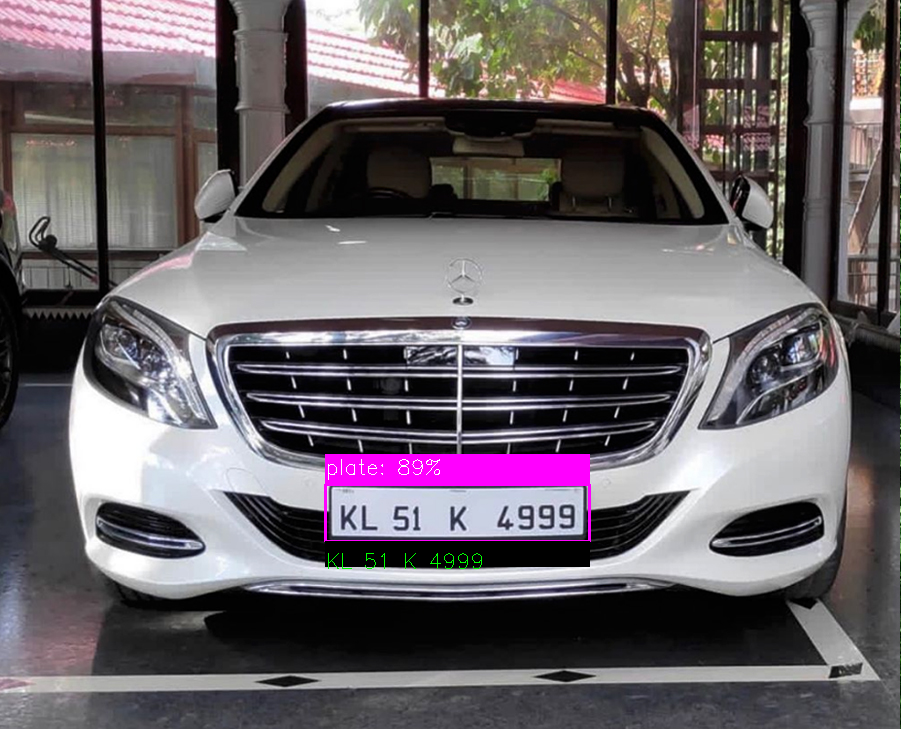

In [26]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()